# Coursework: Age regression from brain MRI

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Predicting the age of a patient from their brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

**The objective for the coursework is to implement two supervised learning approaches for age regression from brain MRI.** We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are two dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented both approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings and illustrate your results.

#### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and two-fold cross-validation of age regression approaches in part A and B. **A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.**

### Install SimpleITK

In [ ]:
! pip3 install SimpleITK==1.2.4 
!pip install --upgrade pip
!pip install seaborn

### Downloading the data

In [ ]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
! unzip brainage-data.zip

--2021-03-01 18:00:24--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468654948 (447M) [application/zip]
Saving to: ‘brainage-data.zip’

brainage-data.zip   100%[===================>] 446.94M  37.2MB/s    in 13s     

2021-03-01 18:00:37 (35.5 MB/s) - ‘brainage-data.zip’ saved [468654948/468654948]

Archive:  brainage-data.zip
   creating: data/
   creating: data/brain_age/
   creating: data/brain_age/images/
  inflating: data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110037_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110045_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110056_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110062_T1w_unbiased.nii.gz  
  inflating

### Setting data directory

In [ ]:
# data directory
data_dir = '/content/drive/MyDrive/MLI_CW/data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [ ]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

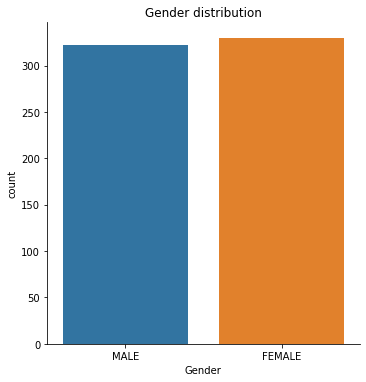

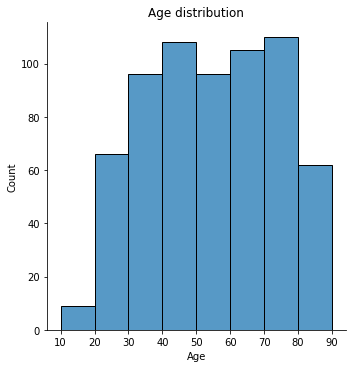

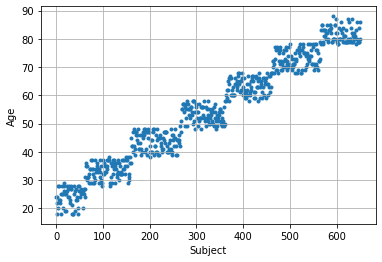

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

# Had to change this because would throw error to use either 'distplot' or 'histplot' because 'distplot' is deprecated
# We can change it back for the final version
#sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
sns.displot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [ ]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image


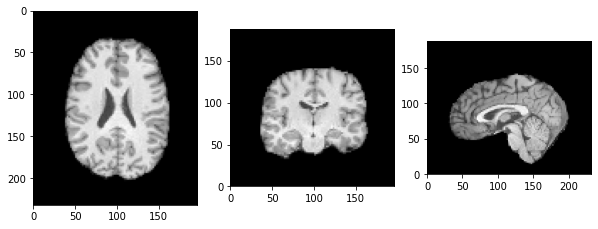

Brain mask


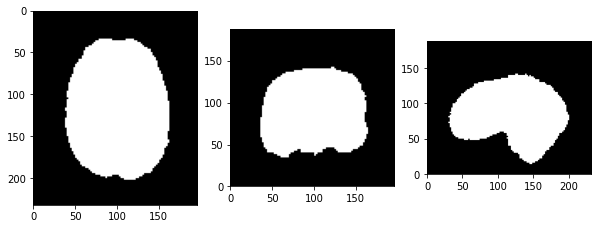

In [ ]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image')
display_image(img, window=400, level=200)

print('Brain mask')
display_image(msk)

## Part A: Age prediction using brain tissue segmentation and volume features

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain tissues include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal or an IDE such as [PyCharm](https://www.jetbrains.com/pycharm/).

#### Imports

In [ ]:
!pip3 install tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [ ]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [ ]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla T4


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [ ]:
rnd_seed = 42 #fixed random seed

img_size = [98, 116, 94]
img_spacing = [2, 2, 2]

num_epochs = 40
learning_rate = 0.00005
batch_size = 1
val_interval = 5

num_classes = 4

out_dir = '/content/drive/MyDrive/MLI_CW/output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [ ]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [ ]:
# LOAD TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# FOR QUICK DEBUGGING, USE THE VALIDATION DATA FOR TRAINING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# LOAD VALIDATION DATA
dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  6.65it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


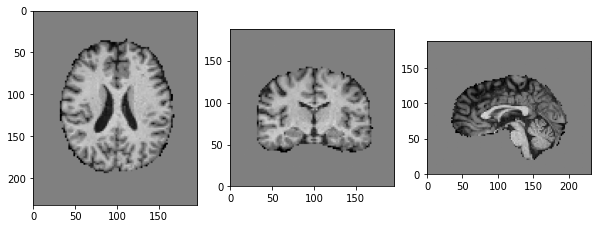

Segmentation


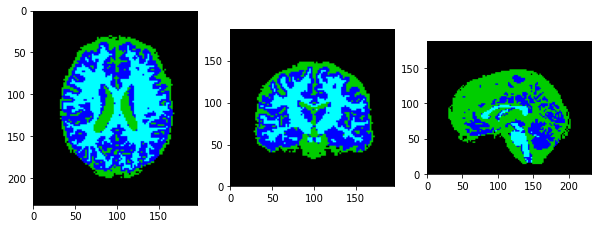

Mask


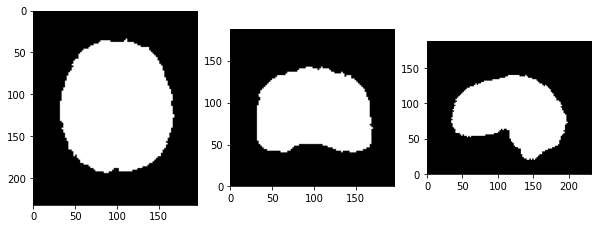

In [ ]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [ ]:
########################################
# BUILD A BETTER MODEL HERE
########################################

class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.main = nn.Sequential(
            nn.Conv3d(1, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(256),
            nn.Conv3d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(128),
            nn.Conv3d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(32),
            nn.Conv3d(32, num_classes, 3, padding=1),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.main(x) # cross-entropy loss expects raw logits and applies softmax

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor Dice scores (or others).

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.942923
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.935697


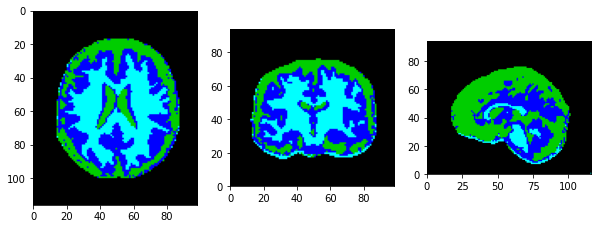

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.857349
+ TRAINING 	Epoch: 3 	Loss: 0.834769
+ TRAINING 	Epoch: 4 	Loss: 0.826516
+ TRAINING 	Epoch: 5 	Loss: 0.804786
--------------------------------------------------
+ VALIDATE 	Epoch: 5 	Loss: 0.802804


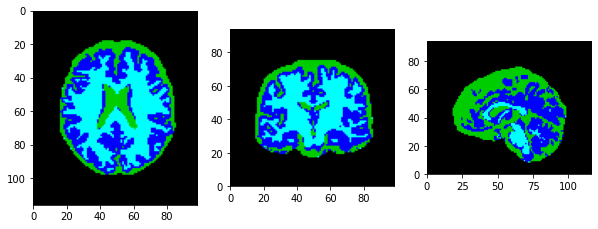

--------------------------------------------------
+ TRAINING 	Epoch: 6 	Loss: 0.793117
+ TRAINING 	Epoch: 7 	Loss: 0.788159
+ TRAINING 	Epoch: 8 	Loss: 0.785858
+ TRAINING 	Epoch: 9 	Loss: 0.783370
+ TRAINING 	Epoch: 10 	Loss: 0.779205
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.780183


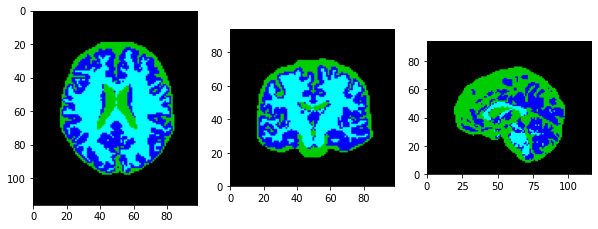

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.783514
+ TRAINING 	Epoch: 12 	Loss: 0.776969
+ TRAINING 	Epoch: 13 	Loss: 0.778418
+ TRAINING 	Epoch: 14 	Loss: 0.775104
+ TRAINING 	Epoch: 15 	Loss: 0.788680
--------------------------------------------------
+ VALIDATE 	Epoch: 15 	Loss: 0.774012


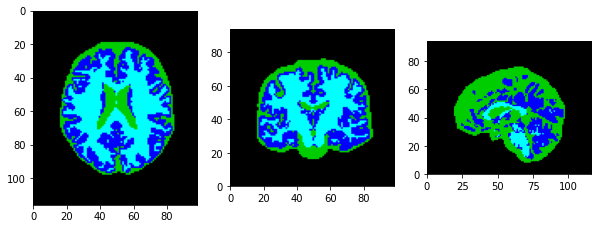

--------------------------------------------------
+ TRAINING 	Epoch: 16 	Loss: 0.777445
+ TRAINING 	Epoch: 17 	Loss: 0.770861
+ TRAINING 	Epoch: 18 	Loss: 0.770496
+ TRAINING 	Epoch: 19 	Loss: 0.769321
+ TRAINING 	Epoch: 20 	Loss: 0.773155
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.772435


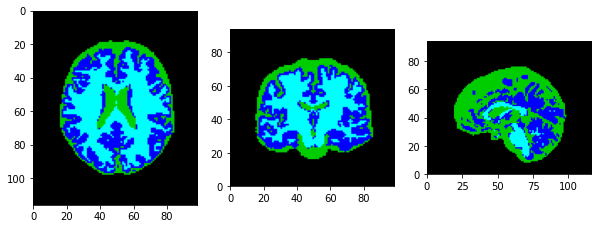

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.768755
+ TRAINING 	Epoch: 22 	Loss: 0.768820
+ TRAINING 	Epoch: 23 	Loss: 0.772886
+ TRAINING 	Epoch: 24 	Loss: 0.766151
+ TRAINING 	Epoch: 25 	Loss: 0.769508
--------------------------------------------------
+ VALIDATE 	Epoch: 25 	Loss: 0.771434


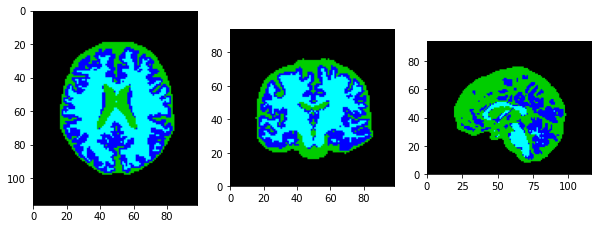

--------------------------------------------------
+ TRAINING 	Epoch: 26 	Loss: 0.766554
+ TRAINING 	Epoch: 27 	Loss: 0.767449
+ TRAINING 	Epoch: 28 	Loss: 0.773912
+ TRAINING 	Epoch: 29 	Loss: 0.772129
+ TRAINING 	Epoch: 30 	Loss: 0.773281
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.767929


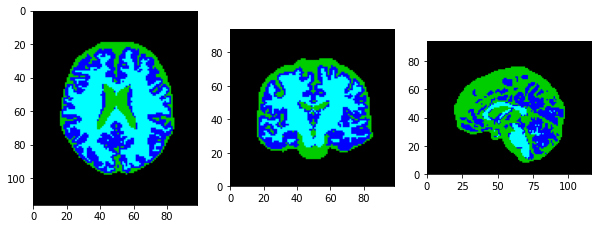

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.766315
+ TRAINING 	Epoch: 32 	Loss: 0.766039
+ TRAINING 	Epoch: 33 	Loss: 0.785629
+ TRAINING 	Epoch: 34 	Loss: 0.771799
+ TRAINING 	Epoch: 35 	Loss: 0.770979
--------------------------------------------------
+ VALIDATE 	Epoch: 35 	Loss: 0.766898


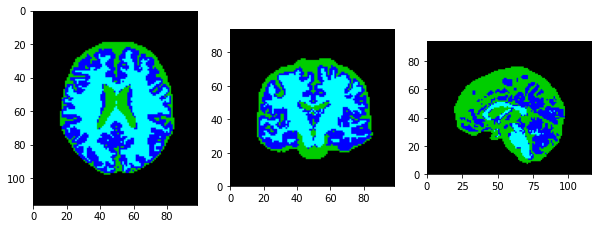

--------------------------------------------------
+ TRAINING 	Epoch: 36 	Loss: 0.768585
+ TRAINING 	Epoch: 37 	Loss: 0.767408
+ TRAINING 	Epoch: 38 	Loss: 0.762107
+ TRAINING 	Epoch: 39 	Loss: 0.763779
+ TRAINING 	Epoch: 40 	Loss: 0.767148
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.766787


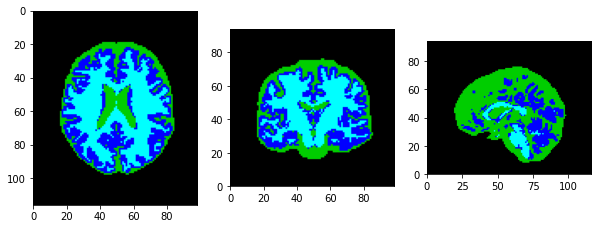

--------------------------------------------------

Finished TRAINING.


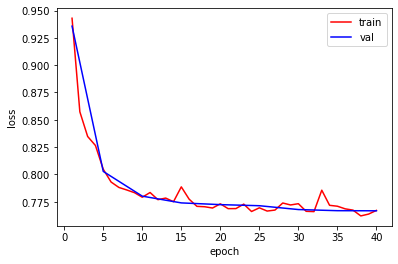

In [ ]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = SimpleNet3D(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        loss = F.cross_entropy(prd, seg.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                loss_val += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
                sum_pts += np.prod(img_size)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [ ]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [01:14<00:00,  6.67it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


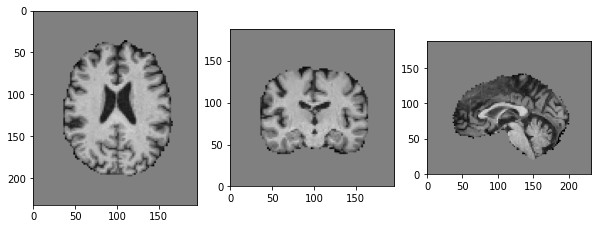

Segmentation


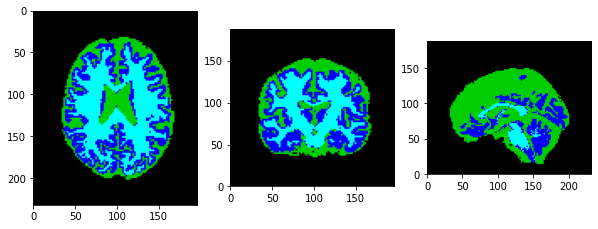

Mask


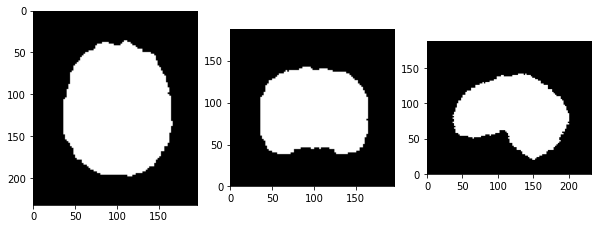

In [ ]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly other metrics) to evaluate the segmentation performance.**

START TESTING...
+ TESTING 	Loss: 0.770719


Reference segmentation


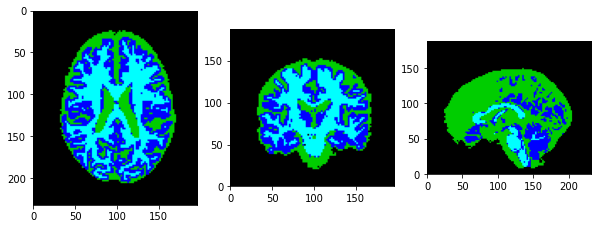

Predicted segmentation


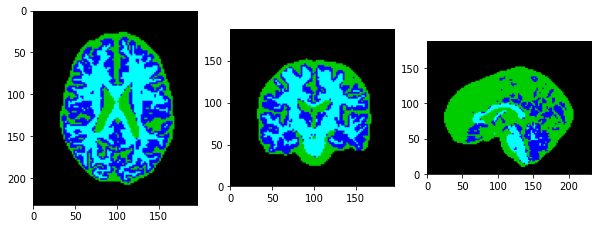


Finished TESTING.


In [ ]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = SimpleNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

# Dice scores corresponding to the 3 classes
dice_scores = [[],[],[]]
# Jaccard index corresponding to the 3 classes
jaccard_scores = [[],[],[]]
# Volume similarity
vol_sim = [[],[],[]]

loss_test = 0
sum_pts = 0
idx_test = 0
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        # Calculate DICE coefficient using predicted and target image
        overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
        
        # Iterate through list of lists (for CSF, GM and WM)
        for i in range(1,4):
            x = sitk.GetArrayFromImage(sample['seg'])
            y = sitk.GetArrayFromImage(prediction)
            # Find all entries in the array for the respective segmentation class
            xs = (x==i).astype(np.int)
            ys = (y==i).astype(np.int)
            xss = sitk.GetImageFromArray(xs)
            yss = sitk.GetImageFromArray(ys)
            overlap_measures_filter.Execute(xss, yss)
            # Dice score
            dice_scores[i-1].append(overlap_measures_filter.GetDiceCoefficient())
            # Jaccard score
            jaccard_scores[i-1].append(overlap_measures_filter.GetJaccardCoefficient())
            # Volume similarity
            vol_sim[i-1].append(overlap_measures_filter.GetVolumeSimilarity())
            
        idx_test += 1
        
        
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

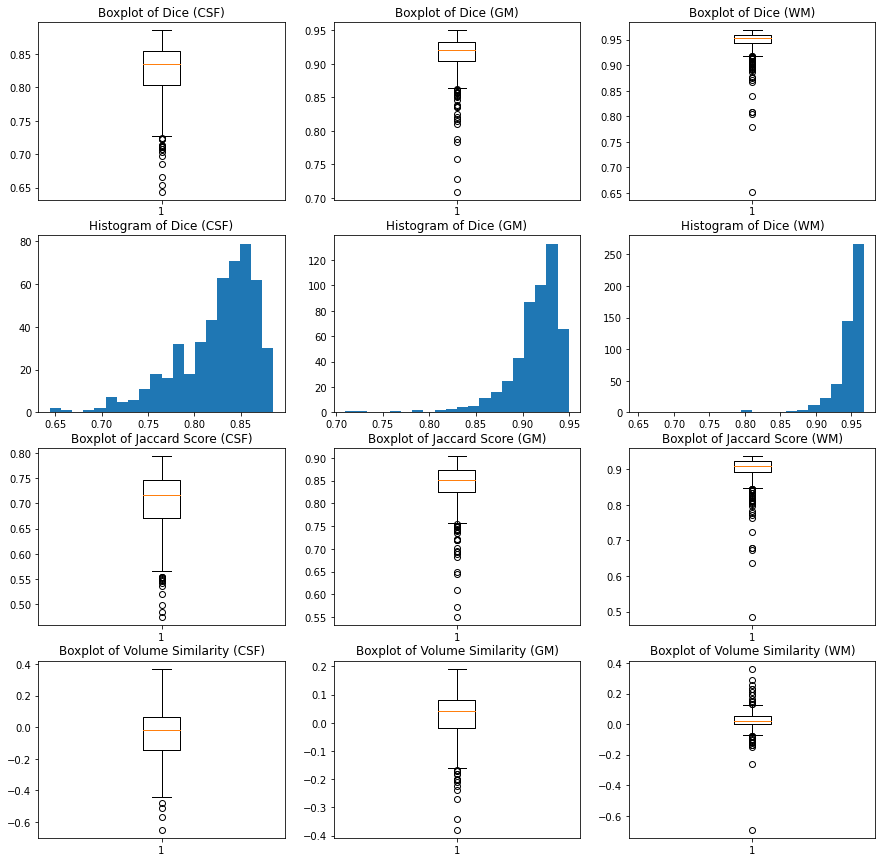

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(15,15))    

# Plot for CSF
axs[0][0].boxplot(dice_scores[0])
axs[0][0].set_title("Boxplot of Dice (CSF)")

# Plot for GM
axs[0][1].boxplot(dice_scores[1])
axs[0][1].set_title("Boxplot of Dice (GM)")

# Plot for WM
axs[0][2].boxplot(dice_scores[2])
axs[0][2].set_title("Boxplot of Dice (WM)")

axs[1][0].hist(dice_scores[0], bins=20)
axs[1][0].set_title("Histogram of Dice (CSF)")

axs[1][1].hist(dice_scores[1], bins=20)
axs[1][1].set_title("Histogram of Dice (GM)")

axs[1][2].hist(dice_scores[2], bins=20)
axs[1][2].set_title("Histogram of Dice (WM)")

axs[2][0].boxplot(jaccard_scores[0])
axs[2][0].set_title("Boxplot of Jaccard Score (CSF)")

axs[2][1].boxplot(jaccard_scores[1])
axs[2][1].set_title("Boxplot of Jaccard Score (GM)")

axs[2][2].boxplot(jaccard_scores[2])
axs[2][2].set_title("Boxplot of Jaccard Score (WM)")

axs[3][0].boxplot(vol_sim[0])
axs[3][0].set_title("Boxplot of Volume Similarity (CSF)")

axs[3][1].boxplot(vol_sim[1])
axs[3][1].set_title("Boxplot of Volume Similarity (GM)")

axs[3][2].boxplot(vol_sim[2])
axs[3][2].set_title("Boxplot of Volume Similarity (WM)")

plt.show()

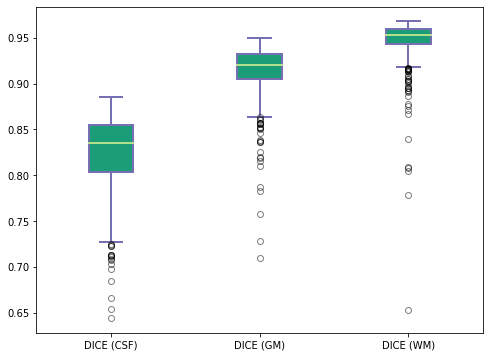

In [ ]:
# DICE Boxplots (on same axis)

fig, ax = plt.subplots(1, figsize=(8,6))

dp = ax.boxplot(dice_scores, patch_artist=True)

for box in dp['boxes']:
    box.set( color='#7570b3', linewidth=2)
    box.set( facecolor = '#1b9e77' )

for whisker in dp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

for cap in dp['caps']:
    cap.set(color='#7570b3', linewidth=2)

for median in dp['medians']:
    median.set(color='#b2df8a', linewidth=2)

for flier in dp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
    
ax.set_xticklabels(['DICE (CSF)', 'DICE (GM)', 'DICE (WM)'])

plt.show()

In [ ]:
print("DICE Mean (CSF): %f" % np.mean(dice_scores[0]))
print("DICE Mean (GM): %f" % np.mean(dice_scores[1]))
print("DICE Mean (WM): %f" % np.mean(dice_scores[2]))

DICE Mean (CSF): 0.824420
DICE Mean (GM): 0.913258
DICE Mean (WM): 0.946738


### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [ ]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = '/content/drive/MyDrive/MLI_CW/output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
#seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        
        ########################################
        # ADD YOUR CODE HERE
        ########################################
        arr_seg = sitk.GetArrayFromImage(seg)
        # Return a sorted list of how many of each number are present
        # We want numbers 1,2,3 (for CSF, GM, WM)
        _, c = np.unique(arr_seg, return_counts=True)
        vols[0][idx] = c[1]
        vols[1][idx] = c[2]
        vols[2][idx] = c[3]

Calculating Features: 100%|██████████| 500/500 [00:17<00:00, 28.78it/s]


Plot features versus age.

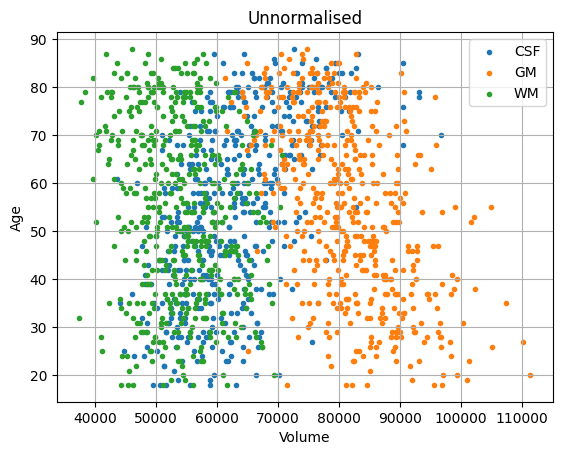

In [ ]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [ ]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))

########################################
# ADD YOUR CODE HERE
########################################
#matter_pixels = np.asarray([sum(vols[:][i] for i in range(vols.shape[1]))])
matter_pixels = np.sum(vols, axis=0)
vols_normalised = np.divide(vols, matter_pixels)


Plot normalised features versus age.

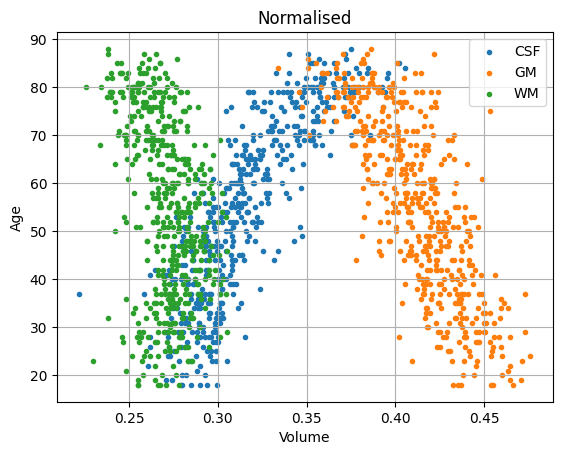

In [ ]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Final data for age regression

In [ ]:
X_train = vols_normalised.T
y_train = meta_data_reg_train['age'].values.reshape(-1,1)

print(X_train.shape)
print(y_train.shape)

(500, 3)
(500, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

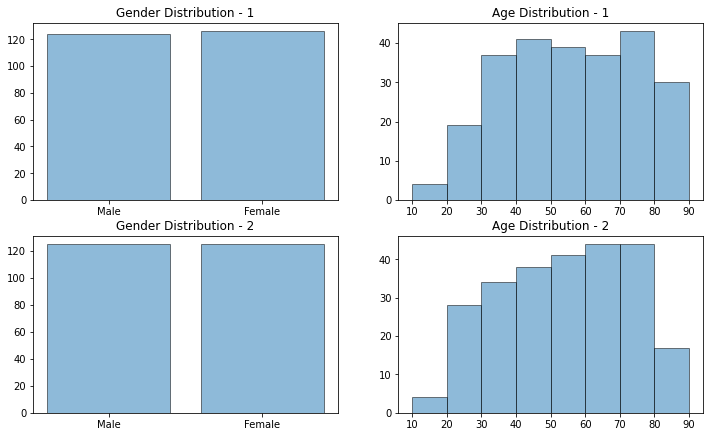

In [ ]:
########################################
# ADD YOUR CODE HERE
########################################

# Split data distributions

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import linear_model

cross_val = KFold(2, shuffle=True, random_state=40)

one_index, two_index = cross_val.split(X_train)

for one_index, two_index in cross_val.split(X_train):
    X_1, X_2 = X_train[one_index,:], X_train[two_index,:]
    age1, age2 = meta_data_reg_train['age'].to_numpy()[one_index], meta_data_reg_train['age'].to_numpy()[two_index]
    gen1, gen2 = meta_data_reg_train['gender_text'].to_numpy()[one_index], meta_data_reg_train['gender_text'].to_numpy()[two_index]

# Plot split dataset distributions
fig = plt.figure(figsize=(12,15))

ax1 = fig.add_subplot(421)
ax1.bar(['Male','Female'], [np.count_nonzero(gen1 == 'MALE'), np.count_nonzero(gen1 == 'FEMALE')],alpha=0.5, edgecolor = 'black')
plt.title('Gender Distribution - 1')

ax2 = fig.add_subplot(422)
ax2.hist(age1, bins=[10,20,30,40,50,60,70,80,90],alpha=0.5, edgecolor = 'black')
plt.title('Age Distribution - 1')

ax3 = fig.add_subplot(423)
ax3.bar(['Male','Female'], [np.count_nonzero(gen2 == 'MALE'), np.count_nonzero(gen2 == 'FEMALE')],alpha=0.5, edgecolor = 'black')
plt.title('Gender Distribution - 2')

ax4 = fig.add_subplot(424)
ax4.hist(age2, bins=[10,20,30,40,50,60,70,80,90],alpha=0.5, edgecolor = 'black')
plt.title('Age Distribution - 2')

y = meta_data_reg_train['age'].values.reshape(-1,1)

In [ ]:
def error_metrics(model_name,y_pred):
    MAE = mean_absolute_error(y, y_pred)
    MSE = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    return MAE, MSE, r2

Ridge  	MAE: 8.138712  	RMSE: 10.147765  	R2: 0.697460


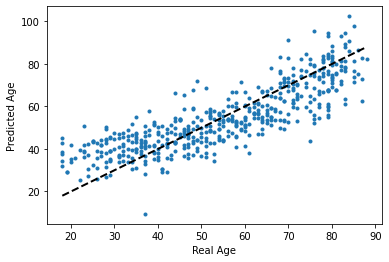

In [ ]:
# RIDGE REGRESSION
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

ridge = Ridge()
grid = dict()
grid['alpha'] = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
grid['solver'] = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
grid['normalize'] = ['True','False']
search = GridSearchCV(ridge, grid, cv=cross_val, scoring='neg_mean_absolute_error')
X = X.copy(order='C')
ridge_GS = search.fit(X,y)

# Cross Validation - Error metrics
ridge_optim = ridge_GS.best_estimator_

# Cross Validation - prediction
y_ridge = cross_val_predict(ridge_optim, X, y, cv=cross_val)

# Error metrics
ridge_MAE = mean_absolute_error(y, y_ridge)
ridge_MSE = mean_squared_error(y, y_ridge)
ridge_r2 = r2_score(y, y_ridge)

print('Ridge  \tMAE: {:.6f}  \tRMSE: {:.6f}  \tR2: {:.6f}'.format(np.mean(ridge_MAE), np.sqrt(np.mean(ridge_MSE)), np.mean(ridge_r2)))

fig, ax = plt.subplots()
ax.scatter(y, y_ridge, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

Ridge  	MAE: 8.134000  	RMSE: 10.146810  	R2: 0.697517


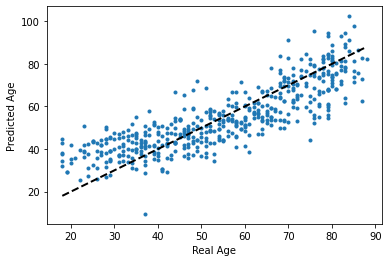

In [ ]:
# LINEAR REGRESSION
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

linear = LinearRegression()

# Cross Validation - prediction
y_linear = cross_val_predict(linear, X, y, cv=cross_val)

# Error metrics
linear_MAE = mean_absolute_error(y, y_linear)
linear_MSE = mean_squared_error(y, y_linear)
linear_r2 = r2_score(y, y_linear)

print('Ridge  \tMAE: {:.6f}  \tRMSE: {:.6f}  \tR2: {:.6f}'.format(np.mean(linear_MAE), np.sqrt(np.mean(linear_MSE)), np.mean(linear_r2)))

fig, ax = plt.subplots()
ax.scatter(y, y_linear, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

NuSVR  	MAE: 7.804075  	RMSE: 9.816886  	R2: 0.716868


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


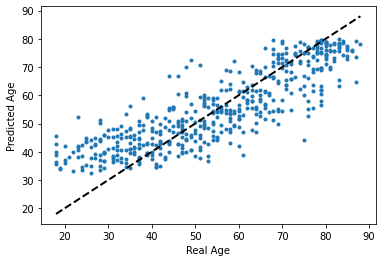

In [ ]:
# NuSVR
from sklearn.svm import NuSVR

# Grid Search
nusvr = NuSVR()
grid = dict()
grid['C'] = np.arange(0.2,1.8,0.02)
grid['nu'] = np.arange(0.05,0.95,0.01)
grid['kernel'] = ['linear', 'rbf']
grid['gamma'] = ['scale','auto']
search = GridSearchCV(nusvr, grid, cv=cross_val, scoring='neg_mean_absolute_error')
nusvr_GS = search.fit(X_train,y_train)

# Optimised NuSVR
nusvr_optim = nusvr_GS.best_estimator_

# Cross Validation - prediction
y_nusvr = cross_val_predict(nusvr_optim, X, y, cv=cross_val)

# Error Metrics
nusvr_MAE = mean_absolute_error(y, y_nusvr)
nusvr_MSE = mean_squared_error(y, y_nusvr)
nusvr_r2 = r2_score(y, y_nusvr)
print('NuSVR  \tMAE: {:.6f}  \tRMSE: {:.6f}  \tR2: {:.6f}'.format(np.mean(nusvr_MAE), np.sqrt(np.mean(nusvr_MSE)), np.mean(nusvr_r2)))

fig, ax = plt.subplots()
ax.scatter(y, y_nusvr, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

In [ ]:
# Gaussian Process Regression
from sklearn.gaussian_process import GaussianProcessRegressor as GP
from sklearn.gaussian_process.kernels import RBF, DotProduct, RationalQuadratic

gp = GP()
grid = [{
    "alpha":  [1e-2, 1e-3],
    "kernel": [RBF(l) for l in np.logspace(-1, 1, 2)]
}, {
    "alpha":  [1e-2, 1e-3],
    "kernel": [DotProduct(sigma_0) for sigma_0 in np.logspace(-1, 1, 2)]
}]
search = GridSearchCV(gp, grid, cv=cross_val, scoring='neg_mean_absolute_error')
gp_GS = search.fit(X_train,y_train)

# Optimised GP
gp_optim = gp_GS.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost	MAE: 7.454491  	RMSE: 9.549122  	R2: 0.732103


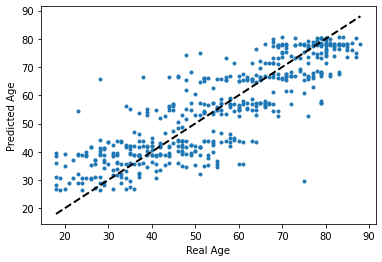

In [ ]:
# ADABOOST
from sklearn.ensemble import AdaBoostRegressor

# Grid Search
ada = AdaBoostRegressor(random_state=0)
grid  = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }
search = GridSearchCV(ada, grid, cv=cross_val, scoring='neg_mean_absolute_error')
ada_GS = search.fit(X,y.reshape(-1))

# Optimised NuSVR
ada_optim = ada_GS.best_estimator_

# Cross Validation - prediction
y_ada = cross_val_predict(ada_optim, X, y, cv=cross_val)

# Error Metrics
error_metrics('AdaBoost',y_ada)

fig, ax = plt.subplots()
ax.scatter(y, y_ada, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

In [ ]:
# POLYNOMIAL FEATURES
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.svm import NuSVR
from sklearn.gaussian_process import GaussianProcessRegressor as GP
from sklearn.gaussian_process.kernels import RBF, DotProduct, RationalQuadratic
from sklearn.ensemble import AdaBoostRegressor

polynomial_degree = 8

X_poly = np.zeros([500,3*polynomial_degree])
for i in range(polynomial_degree):
  X_poly[:,(i*3):(i+1)*3] = X_train ** (i+1)

# Linear Regression
linear_poly = LinearRegression().fit(X_poly,y_train)
y_linear_poly = cross_val_predict(linear_poly, X_train, y_train, cv=cross_val)
MAE_linear, MSE_linear, r2_linear = error_metrics('Linear', y_linear_poly)

# Ridge Regression
ridge = Ridge()
grid = dict()
grid['alpha'] = [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 5, 10, 100, 250, 500, 1000]
grid['solver'] = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
grid['normalize'] = ['True','False']
search = GridSearchCV(ridge, grid, cv=cross_val, scoring='neg_mean_absolute_error')
X_train = X_train.copy(order='C')
ridge_GS = search.fit(X_poly,y_train)
ridge_poly = ridge_GS.best_estimator_
y_ridge_poly = cross_val_predict(ridge_poly, X_train, y_train, cv=cross_val)
MAE_ridge, MSE_ridge, r2_ridge = error_metrics('Ridge', y_ridge_poly)

# NuSVR
nusvr = NuSVR()
grid = dict()
grid['C'] = [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 5, 10, 100]
grid['nu'] = np.arange(0.05,0.95,0.05)
grid['kernel'] = ['linear', 'rbf']
grid['gamma'] = ['scale','auto']
search = GridSearchCV(nusvr, grid, cv=cross_val, scoring='neg_mean_absolute_error')
nusvr_GS = search.fit(X_poly,y_train.reshape(-1))
nusvr_poly = nusvr_GS.best_estimator_
y_nusvr_poly = cross_val_predict(nusvr_poly, X_train, y_train, cv=cross_val)
MAE_nusvr, MSE_nusvr, r2_nusvr = error_metrics('NuSVR', y_nusvr_poly)

# Gaussian Process
gp = GP()
grid = [{"alpha":  [1e-2, 1e-3], "kernel": [RBF(l) for l in np.logspace(-1, 1, 2)]}, 
        {"alpha":  [1e-2, 1e-3],"kernel": [DotProduct(sigma_0) for sigma_0 in np.logspace(-1, 1, 2)]}]
search = GridSearchCV(gp, grid, cv=cross_val, scoring='neg_mean_absolute_error')
gp_GS = search.fit(X_poly,y_train)
gp_poly = gp_GS.best_estimator_
y_gp_poly = cross_val_predict(gp_poly, X_train, y_train, cv=cross_val)
MAE_gp, MSE_gp, r2_gp = error_metrics('GP', y_gp_poly)

# AdaBoost
ada = AdaBoostRegressor(random_state=0)
grid  = {'n_estimators': [50, 100],
         'learning_rate' : [0.01,0.05,0.1,0.3,1],
         'loss' : ['linear', 'square', 'exponential']}
search = GridSearchCV(ada, grid, cv=cross_val, scoring='neg_mean_absolute_error')
ada_GS = search.fit(X_poly,y_train.reshape(-1))
ada_poly = ada_GS.best_estimator_
y_ada_poly = cross_val_predict(ada_poly, X_train, y_train, cv=cross_val)
MAE_ada, MSE_ada, r2_ada = error_metrics('AdaBoost', y_ada_poly)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status

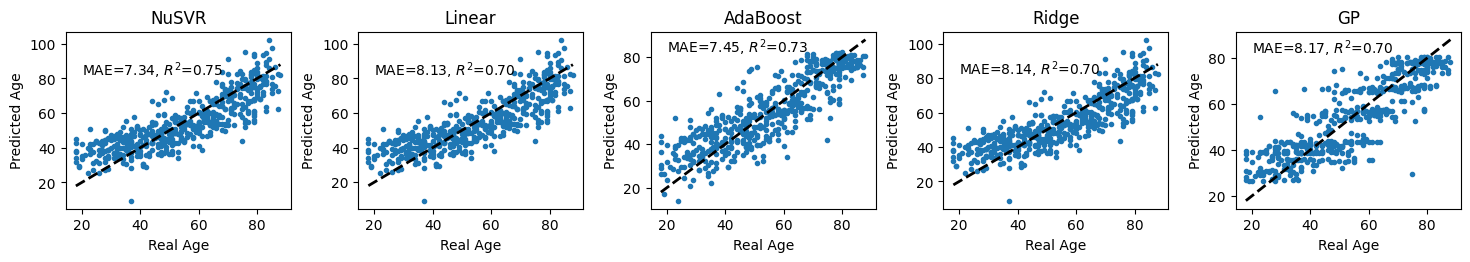

In [ ]:
titles = ['NuSVR', 'Linear', 'AdaBoost', 'Ridge', 'GP']
y_cv_poly = [y_linear_poly, y_ridge_poly, y_nusvr_poly, y_gp_poly, y_ada_poly]
mae_cv = [MAE_nusvr, MAE_linear, MAE_ada, MAE_ridge, MAE_gp]
r2_cv = [r2_nusvr, r2_linear, r2_ada, r2_ridge, r2_gp]

fig, axs = plt.subplots(1,5, figsize=(18, 2.3), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)

axs = axs.ravel()

for i in range(5):

    axs[i].scatter(y_train, y_cv_poly[i], marker='.')
    axs[i].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    axs[i].set_xlabel('Real Age')
    axs[i].set_ylabel('Predicted Age')
    axs[i].set_title(titles[i])
    axs[i].text(20, 82, r'MAE={:.2f}, $R^2$={:.2f}'.format(mae_cv[i], r2_cv[i]))

#plt.savefig('/content/drive/MyDrive/MLI_CW/cv_plots.png', dpi=600, bbox_inches='tight')

### Task A-4: Final test on hold-out data

#### Downloading data

This is only available once the final test data has been released.

In [ ]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
! unzip brainage-testdata.zip

--2021-02-28 17:49:48--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/zip]
Saving to: ‘brainage-testdata.zip.1’

brainage-testdata.z 100%[===================>]   1.49K  --.-KB/s    in 0s      

2021-02-28 17:49:48 (324 MB/s) - ‘brainage-testdata.zip.1’ saved [1521/1521]

Archive:  brainage-testdata.zip
replace data/brain_age/meta/meta_data_regression_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/brain_age/meta/meta_data_regression_test.csv  


#### Loading and pre-processing of testing data

In [ ]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [02:49<00:00,  1.69s/it]


#### Run final testing

In [ ]:
model_dir = os.path.join(out_dir, 'model')
pred_dir = os.path.join(out_dir, 'unseen_test')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = SimpleNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

# Dice scores corresponding to the 3 classes
dice_scores = [[],[],[]]
# Jaccard index corresponding to the 3 classes
jaccard_scores = [[],[],[]]
# Volume similarity
vol_sim = [[],[],[]]

loss_test = 0
sum_pts = 0
idx_test = 0
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        # Calculate DICE coefficient using predicted and target image
        overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
        
        # Iterate through list of lists (for CSF, GM and WM)
        for i in range(1,4):
            x = sitk.GetArrayFromImage(sample['seg'])
            y = sitk.GetArrayFromImage(prediction)
            # Find all entries in the array for the respective segmentation class
            xs = (x==i).astype(np.int)
            ys = (y==i).astype(np.int)
            xss = sitk.GetImageFromArray(xs)
            yss = sitk.GetImageFromArray(ys)
            overlap_measures_filter.Execute(xss, yss)
            # Dice score
            dice_scores[i-1].append(overlap_measures_filter.GetDiceCoefficient())
            # Jaccard score
            jaccard_scores[i-1].append(overlap_measures_filter.GetJaccardCoefficient())
            # Volume similarity
            vol_sim[i-1].append(overlap_measures_filter.GetVolumeSimilarity())
            
        idx_test += 1
        
        
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

NameError: ignored

In [ ]:
import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = '/content/drive/MyDrive/MLI_CW/output/unseen_test/'

meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])
files_reg_seg_test = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_test]

In [ ]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = '/content/drive/MyDrive/MLI_CW/output/unseen_test/'

meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])
files_reg_seg_test = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_test]


# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_test)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_test)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_test[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        
        ########################################
        # ADD YOUR CODE HERE
        ########################################
        arr_seg = sitk.GetArrayFromImage(seg)
        # Return a sorted list of how many of each number are present
        # We want numbers 1,2,3 (for CSF, GM, WM)
        _, c = np.unique(arr_seg, return_counts=True)
        vols[0][idx] = c[1]
        vols[1][idx] = c[2]
        vols[2][idx] = c[3]

Calculating Features: 100%|██████████| 100/100 [00:03<00:00, 29.42it/s]


100


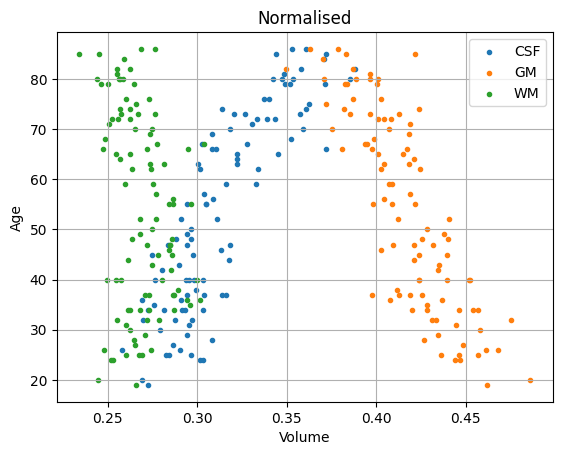

(100, 3)
(100, 1)


In [ ]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_test)))
matter_pixels = np.sum(vols, axis=0)
vols_normalised = np.divide(vols, matter_pixels)

print(len(matter_pixels))

plt.scatter(vols_normalised[0,:],meta_data_reg_test['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_test['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_test['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

X_test = vols_normalised.T
y_test = meta_data_reg_test['age'].values.reshape(-1,1)

print(X_test.shape)
print(y_test.shape)

#Linear Features

In [ ]:
regressors = [nusvr_optim, linear, ada_optim, ridge_optim, gp_optim]

y_preds = []
maes = []
mses = []
r2s = []

for regressor in regressors:
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)
  y_preds.append(y_pred)
  maes.append(mean_absolute_error(y_test,y_pred))
  mses.append(mean_squared_error(y_test,y_pred))
  r2s.append(r2_score(y_test,y_pred))

def mae(y,y_pred):
     y_pred.reshape(-1,1)
     mae = []
     for i in range(len(y)):
         mae.append(abs(y[i][0]-y_pred[i]))
     return mae

mae1 = mae(y_test,y_preds[0])
mae2 = mae(y_test,y_preds[1])
mae3 = mae(y_test,y_preds[2])
mae4 = mae(y_test,y_preds[3])
mae5 = mae(y_test,y_preds[4])

boxes = {'NuSVR': mae1, 
          'Linear': mae2, 
          'AdaBoost': mae3, 
          'Ridge': mae4,
          'GP': mae5}

fig, ax = plt.subplots(figsize=(12,7))
plt.style.use('default')
ax.boxplot(boxes.values())
ax.set_xticklabels(boxes.keys())


NameError: ignored

In [ ]:
titles = ['NuSVR', 'Linear', 'AdaBoost', 'Ridge', 'GP']

fig, axs = plt.subplots(1,5, figsize=(24, 3), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)

axs = axs.ravel()

for i in range(5):

    axs[i].scatter(y_test, y_preds[i], marker='.')
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axs[i].set_xlabel('Real Age')
    axs[i].set_ylabel('Predicted Age')
    axs[i].set_title(titles[i])
    axs[i].text(20, 80, r'MAE={:.2f}, $R^2$={:.2f}'.format(maes[i], r2s[i]))

# Polynomial Features

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nest

[8.154393201205913, 8.081875, 7.707055475236527, 8.077813367018122, 8.315535560250282]


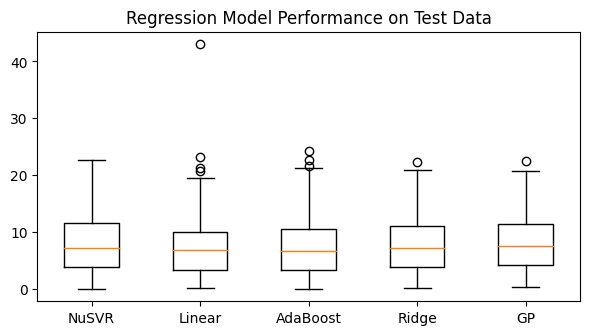

In [ ]:
regressors = [nusvr_poly, linear_poly, ada_poly, ridge_poly, gp_poly]

X_test_poly = np.zeros([100,3*polynomial_degree])
for i in range(polynomial_degree):
  X_test_poly[:,(i*3):(i+1)*3] = X_test ** (i+1)

y_preds_poly = []
maes_poly = []
mses_poly = []
r2s_poly = []

for regressor in regressors:
  regressor.fit(X_poly, y_train)
  y_pred = regressor.predict(X_test_poly)
  y_preds_poly.append(y_pred)
  maes_poly.append(mean_absolute_error(y_test,y_pred))
  mses_poly.append(mean_squared_error(y_test,y_pred))
  r2s_poly.append(r2_score(y_test,y_pred))

print(maes_poly)

def mae(y,y_pred):
     y_pred.reshape(-1,1)
     mae = []
     for i in range(len(y)):
         mae.append(abs(y[i][0]-y_pred[i]))
     return mae

mae1 = mae(y_test,y_preds_poly[0])
mae2 = mae(y_test,y_preds_poly[1])
mae3 = mae(y_test,y_preds_poly[2])
mae4 = mae(y_test,y_preds_poly[3])
mae5 = mae(y_test,y_preds_poly[4])

boxes = {'NuSVR': mae1, 
          'Linear': mae2, 
          'AdaBoost': mae3, 
          'Ridge': mae4,
          'GP': mae5}

fig, ax = plt.subplots(figsize=(7,3.5))
plt.style.use('default')
plt.title('Regression Model Performance on Test Data')
ax.boxplot(boxes.values())
ax.set_xticklabels(boxes.keys())
plt.savefig('/content/drive/MyDrive/MLI_CW/box_plots.png', dpi=600, bbox_inches='tight')

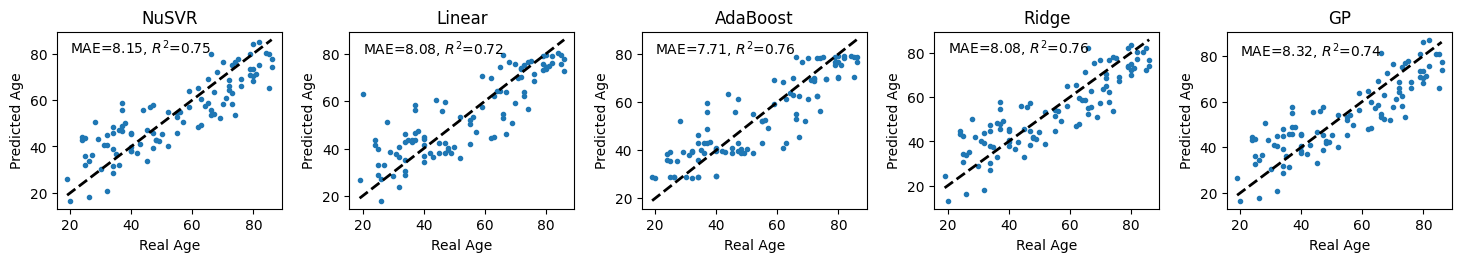

In [ ]:
titles = ['NuSVR', 'Linear', 'AdaBoost', 'Ridge', 'GP']

fig, axs = plt.subplots(1,5, figsize=(18, 2.3), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)

axs = axs.ravel()

for i in range(5):

    axs[i].scatter(y_test, y_preds_poly[i], marker='.')
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axs[i].set_xlabel('Real Age')
    axs[i].set_ylabel('Predicted Age')
    axs[i].set_title(titles[i])
    axs[i].text(20, 80, r'MAE={:.2f}, $R^2$={:.2f}'.format(maes_poly[i], r2s_poly[i]))

#plt.savefig('/content/drive/MyDrive/MLI_CW/test_plots.png', dpi=600, bbox_inches='tight')

## Part B: Age prediction using regression CNNs

For the second approach we will use a convolutional neural network to directly predict a subject's age.

You will need to implement a CNN model that takes an MRI scan as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from previous tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to task A. For the final age prediction model, you should use all 500 subjects for training and you may want to use the 47 subjects that we used for training the tissue segmentation model as your validation data.

*Note:* Similar to task A, you may want to set up a pre-processing pipeline that involves intensity normalisation and resampling of the input data.

In [ ]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim import lr_scheduler
from sklearn.metrics import mean_absolute_error

In [ ]:
# data directory
data_dir = 'data/brain_age/'

In [ ]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, 0, height))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

In [ ]:
# Data helpers from part A

def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImagePartBDataset(Dataset):
    """Dataset for PartB"""

    def __init__(self, file_list_img, file_list_msk, ages_list, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)
            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)
            age = ages_list[idx]

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'msk': msk, 'age': age}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)
        age = sample['age']

        return {'img': image, 'msk': msk, 'age': age}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

In [ ]:
# Switch to GPU if available (from part A)

cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))

Device: cuda:0
GPU: GeForce RTX 2080 Ti


In [ ]:
print_on = True

# Loading the training metadata for part B as a panda dataframe
meta_data_partB_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
# Creating a list of IDs of subjects for the training data
ids_partB_train = list(meta_data_partB_train['subject_id'])
# Creating a list of ages of subjects for the training data
ages_partB_train = list(meta_data_partB_train['age'])
# Creating a list of strings of MRI image filenames for part B
files_partB_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_partB_train]
# Creating a list of strings of mask image filenames for part B
files_partB_mask_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_partB_train]

# Doing the same for the data to be used in the final test
meta_data_partB_final_test = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_partB_final_test = list(meta_data_partB_final_test['subject_id'])
ages_partB_final_test = list(meta_data_partB_final_test['age'])
files_partB_img_final_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_partB_final_test]
files_partB_mask_final_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_partB_final_test]

# Doing the same for the 2-fold cross validation
meta_data_partB_2fold_1, meta_data_partB_2fold_2 = train_test_split(meta_data_partB_train, test_size=0.5)
ids_partB_2fold_1 = list(meta_data_partB_2fold_1['subject_id'])
ids_partB_2fold_2 = list(meta_data_partB_2fold_2['subject_id'])
ages_partB_2fold_1 = list(meta_data_partB_2fold_1['age'])
ages_partB_2fold_2 = list(meta_data_partB_2fold_2['age'])
files_partB_img_2fold_1 = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_partB_2fold_1]
files_partB_img_2fold_2 = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_partB_2fold_2]
files_partB_mask_2fold_1 = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_partB_2fold_1]
files_partB_mask_2fold_2 = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_partB_2fold_2]

if print_on:
    print("Training metadata:")
    print()
    print(meta_data_partB_train)
    print(100*"-")
    print()
    print("List of IDs for training data:")
    print("length = ", len(ids_partB_train))
    print("List of filenames of MRI Images for training data:")
    print("length = ", len(files_partB_img_train))
    print("List of filenames of mask Images for training data:")
    print("length = ", len(files_partB_mask_train))
    print("List of ages for training data:")
    print("length = ", len(ages_partB_train))
    print(100*"-")
    print()
    
    print("Final test metadata:")
    print()
    print(meta_data_partB_final_test)
    print(100*"-")
    print()
    print("List of IDs for final test data:")
    print("length = ", len(ids_partB_final_test))
    print("List of filenames of MRI Images for final test data:")
    print("length = ", len(files_partB_img_final_test))
    print("List of filenames of mask Images for final test data:")
    print("length = ", len(files_partB_mask_final_test))
    print("List of ages for final test data:")
    print("length = ", len(ages_partB_final_test))
    print(100*"-")
    print()
    
    print("Cross Validation Data 1st Fold")
    print()
    print(meta_data_partB_2fold_1)
    print(100*"-")
    print()
    print("List of IDs for 1st fold data:")
    print("length = ", len(ids_partB_2fold_1))
    print("List of filenames of MRI Images for 1st fold data:")
    print("length = ", len(files_partB_img_2fold_1))
    print("List of filenames of mask Images for 1st fold data:")
    print("length = ", len(files_partB_mask_2fold_1))
    print("List of ages for 1st fold data:")
    print("length = ", len(ages_partB_2fold_1))
    print(100*"-")
    print()
    
    print("Cross Validation Data 2nd Fold")
    print()
    print(meta_data_partB_2fold_2)
    print(100*"-")
    print()
    print("List of IDs for 2nd fold data:")
    print("length = ", len(ids_partB_2fold_2))
    print("List of filenames of MRI Images for 2nd fold data:")
    print("length = ", len(files_partB_img_2fold_2))
    print("List of filenames of mask Images for 2nd fold data:")
    print("length = ", len(files_partB_mask_2fold_2))
    print("List of ages for 2nd fold data:")
    print("length = ", len(ages_partB_2fold_2))
    print(100*"-")
    print()

Training metadata:

     Unnamed: 0 subject_id  age  gender_code gender_text
0           456   CC520745   63            2      FEMALE
1           431   CC520239   65            2      FEMALE
2           545   CC620592   74            2      FEMALE
3           177   CC310391   41            1        MALE
4           557   CC621011   76            1        MALE
..          ...        ...  ...          ...         ...
495         379   CC510258   60            1        MALE
496         420   CC520127   66            1        MALE
497         488   CC610462   76            2      FEMALE
498          77   CC210657   37            1        MALE
499         499   CC610653   71            1        MALE

[500 rows x 5 columns]
----------------------------------------------------------------------------------------------------

List of IDs for training data:
length =  500
List of filenames of MRI Images for training data:
length =  500
List of filenames of mask Images for training data:
length =

Data for subject of age:  63

MR Image


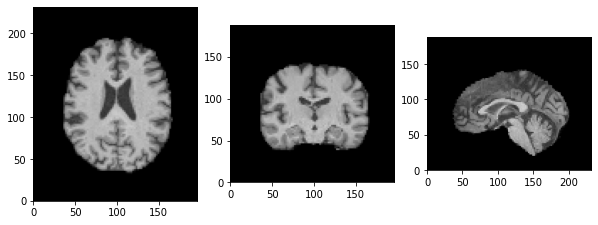

Image size =  (98, 116, 94)
Image spacing =  (2.0, 2.0, 2.0)
----------------------------------------------------------------------------------------------------

Mask Image


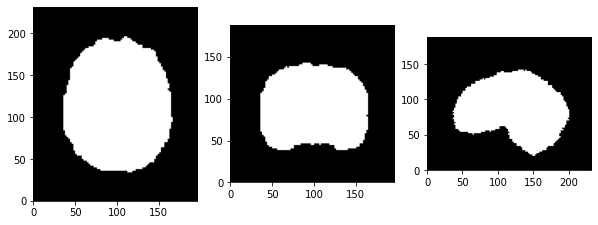

Mask size =  (98, 116, 94)
Mask spacing =  (2.0, 2.0, 2.0)


In [ ]:
# Get a 3D MRI image, view it and extract some info about it

print_on = True

idx = 0
ID = ids_partB_train[idx]
age = ages_partB_train[idx]
image_filename = files_partB_img_train[idx]
img = sitk.ReadImage(image_filename)
mask_filename = files_partB_mask_train[idx]
msk = sitk.ReadImage(mask_filename)

if print_on:
    print("Data for subject of age: ", age)
    print()
    print('MR Image')
    display_image(img, window=400, level=200)
    print("Image size = ", img.GetSize())
    print("Image spacing = ", img.GetSpacing())
    print(100*"-")
    print()
    print('Mask Image')
    display_image(msk)
    print("Mask size = ", msk.GetSize())
    print("Mask spacing = ", msk.GetSpacing())

In [ ]:
rnd_seed = 42 #fixed random seed

img_size = [96, 96, 96]
img_spacing = [2, 2, 2]

num_epochs = 120
learning_rate = 0.00001
batch_size = 4
val_interval = 10

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [ ]:
# Loading data and creating dataloaders for 2-fold cross validation

# First fold
dataset_2fold_1 = ImagePartBDataset(files_partB_img_2fold_1, files_partB_mask_2fold_1, np.array(ages_partB_2fold_1).astype('float32'), img_spacing, img_size)
dataloader_2fold_1 = torch.utils.data.DataLoader(dataset_2fold_1, batch_size=batch_size, shuffle=True)

# Second fold
dataset_2fold_2 = ImagePartBDataset(files_partB_img_2fold_2, files_partB_mask_2fold_2, np.array(ages_partB_2fold_2).astype('float32'), img_spacing, img_size)
dataloader_2fold_2 = torch.utils.data.DataLoader(dataset_2fold_2, batch_size=batch_size, shuffle=True)

Loading Data: 100%|██████████| 250/250 [00:33<00:00,  7.52it/s]


Batch of inputs (batch size = 4)
type:  <class 'dict'>
keys:  dict_keys(['img', 'msk', 'age'])

Under key 'img' :
type:  <class 'torch.Tensor'>
shape:  torch.Size([4, 1, 96, 96, 96])
dtype:  torch.float32

Under key 'msk' :
type:  <class 'torch.Tensor'>
shape:  torch.Size([4, 1, 96, 96, 96])
dtype:  torch.uint8

Under key 'age' :
type:  <class 'torch.Tensor'>
shape:  torch.Size([4])
dtype:  torch.float32
----------------------------------------------------------------------------------------------------

2D slice of sample image to be input to network

max voxel intensity = 2.0017776489257812
min voxel intensity = -3.2085654735565186
background voxel intensity= 0.0


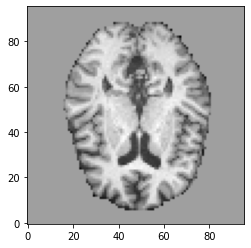

In [ ]:
# Inspecting a dataloader (they are both equivalent)

it = iter(dataloader_2fold_1)

num_batches_to_print = 1
batch_idx = 0

while batch_idx < num_batches_to_print:
    batch_of_inputs = next(it)
    print("Batch of inputs (batch size = {})".format(batch_size))
    print("type: ", type(batch_of_inputs))
    print("keys: ", batch_of_inputs.keys())
    print()
    print("Under key 'img' :")
    print("type: ", type(batch_of_inputs["img"]))
    print("shape: ", batch_of_inputs["img"].shape)
    print("dtype: ", batch_of_inputs["img"].dtype)
    print()
    print("Under key 'msk' :")
    print("type: ", type(batch_of_inputs["msk"]))
    print("shape: ", batch_of_inputs["msk"].shape)
    print("dtype: ", batch_of_inputs["msk"].dtype)
    print()
    print("Under key 'age' :")
    print("type: ", type(batch_of_inputs["age"]))
    print("shape: ", batch_of_inputs["age"].shape)
    print("dtype: ", batch_of_inputs["age"].dtype)
    print(100*"-")
    print()
    
    img_array = batch_of_inputs["img"][0, 0, :, :, :]
    plt.imshow(img_array[40, :, :], cmap='gray', origin='lower')
    print("2D slice of sample image to be input to network")
    print()
    print("max voxel intensity =", torch.max(img_array).item())
    print("min voxel intensity =", torch.min(img_array).item())
    print("background voxel intensity=", torch.mode(img_array.reshape(-1))[0].item())
    
    batch_idx += 1

In [ ]:
class LeNet3D(nn.Module):
    def __init__(self):
        super(LeNet3D, self).__init__()
        
        self.net = nn.Sequential(
            
            # Input shape = (N x 1 x 94 x 94 x 94)
            nn.Conv3d(1, 8, kernel_size=(3, 3, 3), bias=False), # Don't need the bias term because it is included in the batchnorm
            nn.BatchNorm3d(8),
            nn.ReLU(),
            # Input shape = (N x 8 x 92 x 92 x 92)
            nn.MaxPool3d(kernel_size=(2, 2, 2)),         
            
            # Input shape = (N x 8 x 46 x 46 x 46)
            nn.Conv3d(8, 32, kernel_size=(3, 3, 3), bias=False),
            nn.ReLU(),
            nn.BatchNorm3d(32),
            # Input shape = (N x 32 x 44 x 44 x 44)
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
            
            # Input shape = (N x 32 x 22 x 22 x 22)
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), bias=False),
            nn.ReLU(),
            nn.BatchNorm3d(64),
            # Input shape = (N x 64 x 20 x 20 x 20)
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
            
            # Input shape = (N x 64 x 10 x 10 x 10)
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), bias=False),
            nn.ReLU(),
            nn.BatchNorm3d(128),
            # Input shape = (N x 128 x 8 x 8 x 8)
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
            # Output shape = (N x 128 x 4 x 4 x 4)
            
            # Input shape = (N x 128 x 4 x 4 x 4)
            nn.Conv3d(128, 256, kernel_size=(3, 3, 3), bias=False),
            nn.ReLU(),
            nn.BatchNorm3d(256),
            # Input shape = (N x 256 x 2 x 2 x 2)
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
            # Output shape = (N x 256 x 1 x 1 x 1)
        )
        
        # Input shape = (N x 256*1*1*1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256*1*1*1, 1)
        # Output shape = (N x 1)

    def forward(self, x):
        
        x = self.net(x)
        x = x.view(x.size(0), -1)
        #x = self.dropout(x)
        out = self.fc(x)
        
        return out
    
model = LeNet3D()
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

Total number of parameters is: 1169577
LeNet3D(
  (net): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (9): ReLU()
    (10): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (13)

In [ ]:
# Creating, training and testing the model using the 1st fold for training and the 2nd fold for cross validation

def cross_val1():
    model_dir = os.path.join(out_dir, 'PartB_model')
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    torch.manual_seed(rnd_seed) #fix random seed

    model = LeNet3D().to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_train_log = []
    loss_val_log = []
    epoch_val_log = []
    MAE_val = []

    #print('START TRAINING...')
    for epoch in range(1, num_epochs + 1):

        model.train()
        # Training
        for batch_idx, batch_sample in enumerate(dataloader_2fold_1):
            # img_batch.shape = (batch_size x 1 x img_depth x img_height x img_width)
            img_batch = batch_sample['img'].to(device)
            # age_truths_batch.shape = (batch_size)
            age_truths_batch = batch_sample['age'].to(device)
            optimizer.zero_grad()
            # age_preds_batch.shape = (batch_size)
            age_preds_batch = model(img_batch).reshape(-1)

            # formula used: loss = sum( (age_preds_batch - age_truths_batch) ** 2) / len(age_preds_batch)
            loss = F.mse_loss(age_preds_batch, age_truths_batch)
            loss.backward()

            optimizer.step()

        loss_train_log.append(loss.item())

#         print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))


        # Validation
        if epoch == 1 or epoch % val_interval == 0:
            model.eval()
            loss_val = 0
            sum_pts = 0
            loss_mae_val = 0
            with torch.no_grad():
                for batch_sample in dataloader_2fold_2:
                    img_batch = batch_sample['img'].to(device)
                    age_truths_batch = batch_sample['age'].to(device)
                    age_preds_batch = model(img_batch).reshape(-1)
                    loss_val += F.mse_loss(age_preds_batch, age_truths_batch, reduction='sum').item()
                    loss_mae_val += mean_absolute_error(list(age_truths_batch.detach().cpu()), list(age_preds_batch.detach().cpu()))
                loss_mae_val = loss_mae_val/len(dataloader_2fold_2)
            loss_val = loss_val / len(ids_partB_2fold_2)
            loss_val_log.append(loss_val)
            epoch_val_log.append(epoch)
            MAE_val.append(loss_mae_val)

#             print('--------------------------------------------------')
#             print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f} \tMAE: {:.6f}'.format(epoch, loss_val, loss_mae_val))
#             print('--------------------------------------------------')

#     torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

#     print('\nFinished TRAINING.')

#     plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
#     plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
#     plt.legend(loc='upper right')
#     plt.xlabel('Number of Epochs')
#     plt.ylabel('MSE Loss')
#     plt.grid()
#     plt.show()

    val_loss_last_epoch_fold1 = loss_val_log[-1]

    return loss_mae_val, loss_val

In [ ]:
# Creating, training and testing the model using the 2nd fold for training and the 1st fold for cross validation
def cross_val2():
    model_dir = os.path.join(out_dir, 'PartB_model')
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    torch.manual_seed(rnd_seed) #fix random seed

    model = LeNet3D().to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_train_log = []
    loss_val_log = []
    epoch_val_log = []
    MAE_val = []

    #print('START TRAINING...')
    for epoch in range(1, num_epochs + 1):

        model.train()
        # Training
        for batch_idx, batch_sample in enumerate(dataloader_2fold_2):
            # img_batch.shape = (batch_size x 1 x img_depth x img_height x img_width)
            img_batch = batch_sample['img'].to(device)
            # age_truths_batch.shape = (batch_size)
            age_truths_batch = batch_sample['age'].to(device)
            optimizer.zero_grad()
            # age_preds_batch.shape = (batch_size)
            age_preds_batch = model(img_batch).reshape(-1)

            # formula used: loss = sum( (age_preds_batch - age_truths_batch) ** 2) / len(age_preds_batch)
            loss = F.mse_loss(age_preds_batch, age_truths_batch)
            loss.backward()

            optimizer.step()

        loss_train_log.append(loss.item())

#         print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))


        # Validation
        if epoch == 1 or epoch % val_interval == 0:
            model.eval()
            loss_val = 0
            sum_pts = 0
            loss_mae_val = 0
            with torch.no_grad():
                for batch_sample in dataloader_2fold_1:
                    img_batch = batch_sample['img'].to(device)
                    age_truths_batch = batch_sample['age'].to(device)
                    age_preds_batch = model(img_batch).reshape(-1)
                    loss_val += F.mse_loss(age_preds_batch, age_truths_batch, reduction='sum').item()
                    loss_mae_val += mean_absolute_error(list(age_truths_batch.detach().cpu()), list(age_preds_batch.detach().cpu()))
                loss_mae_val = loss_mae_val/len(dataloader_2fold_2)
            loss_val = loss_val / len(ids_partB_2fold_1)
            loss_val_log.append(loss_val)
            epoch_val_log.append(epoch)
            MAE_val.append(loss_mae_val)

#             print('--------------------------------------------------')
#             print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f} \tMAE: {:.6f}'.format(epoch, loss_val, loss_mae_val))
#             print('--------------------------------------------------')

#     torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

#     print('\nFinished TRAINING.')

#     plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
#     plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
#     plt.legend(loc='upper right')
#     plt.xlabel('Number of Epochs')
#     plt.ylabel('MSE Loss')
#     plt.grid()
#     plt.show()

    val_loss_last_epoch_fold2 = loss_val_log[-1]
    return loss_mae_val, loss_val

In [ ]:
# Hyper-parameter tuning for 2-fold cross val
lr = [0.001, 0.0001, 0.00001, 0.000001]
bs = [32, 16, 8, 4, 2]
num_epochs = 120

mae_losses = []
mse_losses = []

for b in bs:
    dataset_2fold_1 = ImagePartBDataset(files_partB_img_2fold_1, files_partB_mask_2fold_1, np.array(ages_partB_2fold_1).astype('float32'), img_spacing, img_size)
    dataloader_2fold_1 = torch.utils.data.DataLoader(dataset_2fold_1, batch_size=batch_size, shuffle=True)
    dataset_2fold_2 = ImagePartBDataset(files_partB_img_2fold_2, files_partB_mask_2fold_2, np.array(ages_partB_2fold_2).astype('float32'), img_spacing, img_size)
    dataloader_2fold_2 = torch.utils.data.DataLoader(dataset_2fold_2, batch_size=batch_size, shuffle=True)
    for l in lr:
        learning_rate = l
        batch_size = b
        mae1, mse1 = cross_val1()
        mae2, mse2 = cross_val2()
        mae_total = (mae1+mae2)*0.5
        mse_total = (mse1+mse2)*0.5
        mae_losses.append([l, b, mae_total])
        mse_losses.append([l, b, mse_total])
        print("LR: %f\t BS:%f\t MSE: %f\t MAE: %f\t" %(l, b, mse_total, mae_total))

In [ ]:
rnd_seed = 42 #fixed random seed

img_size = [96, 96, 96]
img_spacing = [2, 2, 2]

num_epochs = 120
learning_rate = 0.0001
batch_size = 2
val_interval = 10

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [ ]:
# Loading data and creating dataloaders for final training and testing

# Final Training
dataset_train = ImagePartBDataset(files_partB_img_train, files_partB_mask_train, np.array(ages_partB_train).astype('float32'), img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Final Testing
dataset_test = ImagePartBDataset(files_partB_img_final_test, files_partB_mask_final_test, np.array(ages_partB_final_test).astype('float32'), img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 47/47 [00:06<00:00,  7.42it/s]


START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 1083.072632
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 280.170057 	MAE: 35.257512
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 215.358337
+ TRAINING 	Epoch: 3 	Loss: 135.355911
+ TRAINING 	Epoch: 4 	Loss: 180.042557
+ TRAINING 	Epoch: 5 	Loss: 59.877071
+ TRAINING 	Epoch: 6 	Loss: 46.970139
+ TRAINING 	Epoch: 7 	Loss: 85.643661
+ TRAINING 	Epoch: 8 	Loss: 15.745036
+ TRAINING 	Epoch: 9 	Loss: 8.264951
+ TRAINING 	Epoch: 10 	Loss: 9.392594
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 10.052262 	MAE: 5.649995
--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.629439
+ TRAINING 	Epoch: 12 	Loss: 3.678895
+ TRAINING 	Epoch: 13 	Loss: 0.477238
+ TRAINING 	Epoch: 14 	Loss: 0.195295
+ TRAINING 	Epoch: 15 	Loss: 0.045347
+ TRAINING 	Epoch: 16 	Loss: 0.679357
+ TRAINING 	Epoch: 17 	Loss: 0.062160
+ TRAINING 	Epoch: 

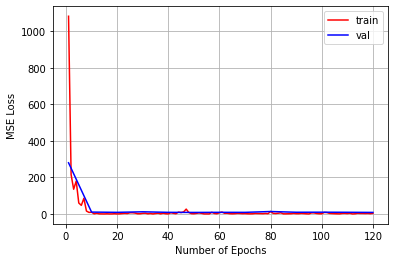

In [ ]:
model_dir = os.path.join(out_dir, 'PartB_model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = LeNet3D().to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
MAE_val = []

print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        # img_batch.shape = (batch_size x 1 x img_depth x img_height x img_width)
        img_batch = batch_samples['img'].to(device)
        # age_truths_batch.shape = (batch_size)
        age_truths_batch = batch_samples['age'].to(device)
        optimizer.zero_grad()
        # age_preds_batch.shape = (batch_size)
        age_preds_batch = model(img_batch).reshape(-1)
        
        # formula used: loss = sum( (age_preds_batch - age_truths_batch) ** 2) / len(age_preds_batch)
        loss = F.mse_loss(age_preds_batch, age_truths_batch)
        loss.backward()
        optimizer.step()
    
    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    
    # Test
    if epoch == 1 or epoch % val_interval == 0:
        model.eval()
        loss_val = 0
        sum_pts = 0
        loss_mae_val = 0
        with torch.no_grad():
            for batch_sample in dataloader_test:
                img_batch = batch_sample['img'].to(device)
                age_truths_batch = batch_sample['age'].to(device)
                age_preds_batch = model(img_batch).reshape(-1)
                loss_val += F.mse_loss(age_preds_batch, age_truths_batch, reduction='sum').item()
                loss_mae_val += mean_absolute_error(list(age_truths_batch.detach().cpu()), list(age_preds_batch.detach().cpu()))
            loss_mae_val = loss_mae_val/len(dataloader_test)
        
        loss_val = loss_val / len(ids_partB_2fold_2)
        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)
        MAE_val.append(loss_mae_val)
        
        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f} \tMAE: {:.6f}'.format(epoch, loss_val, loss_mae_val))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('Number of Epochs')
plt.ylabel('MSE Loss')
plt.grid()
plt.show()

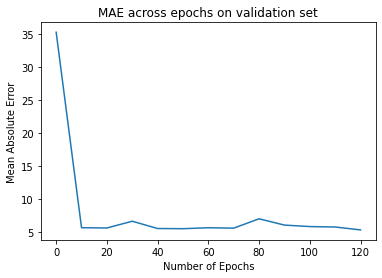

In [ ]:
plt.plot([i*10 for i in range(13)], MAE_val)
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("MAE across epochs on validation set")
plt.show()

In [ ]:
train_pred = []
train_truth = []

test_pred = []
test_truth = []

for batch_idx, batch_samples in enumerate(dataloader_test):
    img_batch = batch_samples['img'].to(device)
    # age_truths_batch.shape = (batch_size)
    age_truths_batch = batch_samples['age'].to(device)
    # age_preds_batch.shape = (batch_size)
    age_preds_batch = model(img_batch).reshape(-1)
    test_truth.append(age_truths_batch.item())
    test_pred.append(age_preds_batch.item())
    
for batch_idx, batch_samples in enumerate(dataloader_train):
    img_batch = batch_samples['img'].to(device)
    # age_truths_batch.shape = (batch_size)
    age_truths_batch = batch_samples['age'].to(device)
    # age_preds_batch.shape = (batch_size)
    age_preds_batch = model(img_batch).reshape(-1)
    train_pred += list(age_truths_batch.detach().cpu())
    train_truth += list(age_preds_batch.detach().cpu())
    


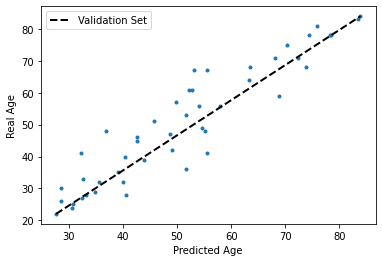

Final MAE on Validation Set: 5.314389


In [ ]:
fig, ax = plt.subplots()
ax.scatter(test_pred, test_truth, marker='.')
ax.plot([min(test_pred), max(test_pred)], [min(test_truth), max(test_truth)], 'k--', lw=2, label = 'Validation Set')
ax.set_xlabel('Predicted Age')
ax.set_ylabel('Real Age')
plt.legend()
plt.show()

print("Final MAE on Validation Set: %f" %mean_absolute_error(test_pred, test_truth))

In [ ]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
! unzip brainage-testdata.zip

--2021-02-28 18:41:03--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/zip]
Saving to: ‘brainage-testdata.zip’

brainage-testdata.z 100%[===================>]   1.49K  --.-KB/s    in 0s      

2021-02-28 18:41:03 (307 MB/s) - ‘brainage-testdata.zip’ saved [1521/1521]

Archive:  brainage-testdata.zip
  inflating: data/brain_age/meta/meta_data_regression_test.csv  


Loading Data: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


In [ ]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
meta_data = meta_data_reg_test
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_2fold_2 = ImagePartBDataset(files_partB_img_2fold_2, files_partB_mask_2fold_2, np.array(ages_partB_2fold_2).astype('float32'), img_spacing, img_size)
fdataset_test = ImagePartBDataset(files_seg_img_test, files_seg_msk_test, np.array([int(meta_data['age'][i]) for i in range(100)]).flatten(), img_spacing, img_size)
fdataloader_test = torch.utils.data.DataLoader(fdataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:13<00:00,  7.36it/s]


In [ ]:
fmodel = LeNet3D()
fmodel.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
fmodel.to(device)
fmodel.eval()
    
print('START TESTING...')

loss_val = 0
loss_mae_val = 0
pred_age_list = []
truth_age_list = []

with torch.no_grad():
    for idx, data_sample in enumerate(fdataloader_test,0):
        img = data_sample['img'].to(device)
        age_truths = data_sample['age']
        age_preds = fmodel(img).reshape(-1)
        pred_age_list.append(age_preds.item())
        truth_age_list.append(age_truths)

mae_final = mean_absolute_error(pred_age_list, truth_age_list)
print('+ TESTING \tMAE on Test Set: %f' %(mae_final))


print('\nFinished TESTING.')

START TESTING...
+ TESTING 	MAE on Test Set: 6.587496

Finished TESTING.
